# Predicting RSI values using LSTMs

## Introduction

This project aims to use a use a Long Short Term Memory (LSTM) neural network to predict the Relative Strength Index (RSI) of a security. The RSI is a momentum indicator, used in technical analysis, that measures the speed and magnitude of a security's recent price changes to evaluate overvalued and undervalued conditions. 

The RSI is displayed as an oscillator on the scale of 0 to 100 and is typically calculated using a 14-day period. An RSI above 70 is considered overbought, while an RSI below 30 is considered oversold. 

RSI is found using a two-part calculation starting with the following formula:
$$RSI_{\text{step one}} = 100 - \frac{100}{1+\frac{\overline{gains}}{\overline{losses}}}$$

Where the average gain and average loss are calculated using the following formulas:
$$\text{$\overline{gains}$} = \frac{\sum\text{ gains over past } n \text{ days}}{n}$$
$$\text{$\overline{losses}$} = \frac{\sum\text{ losses over past } n \text{ days}}{n}$$
Periods of gain are counted as 0 in the losses calculation and vice versa.
The standard nuymber of periods used to calculate RSI is 14 days. 

The second part of the calculation is to smooth the RSI value using the following formula after 14 periods of data have been collected:
$$RSI_{\text{step two}} = 100 - \frac{100}{1 + \frac{Previous \ \overline{gains} \ \cdot \ (n-1)+ Current \ gain }{Previous \text{ } \overline{losses} \cdot (n-1) + Current \ gain}}$$
Where n is the number of periods used to calculate the RSI.

## Data Preparation

### Computing RSI Values

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

def rsi(data, window=14):
    delta = data['Close'].diff(1)
    
    gains, losses = delta.where(delta > 0, 0), -delta.where(delta < 0, 0)

    avg_gain, avg_loss = np.mean(gains.iloc[1:window+1]), np.mean(losses.iloc[1:window+1])

    rsi_values  = ([np.nan] * window)
    if avg_loss == 0:
        rsi_values.append(100)
    else: 
        rsi_values.append((100 - (100 / (1 + (avg_gain / avg_loss)))))

    for i in range(window + 1, len(delta)):
        avg_gain, avg_loss = (avg_gain * (window-1) + gains.iloc[i]) / window, (avg_loss * (window-1) + losses.iloc[i]) / window

        rsi_values.append(100 - (100 / (1 + (avg_gain/avg_loss))))

    return rsi_values

### Fetching Data

In [43]:
stocks, stock_data = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NFLX", "NVDA", "QQQ"], {}


for stock in stocks:
    df = pd.DataFrame(yf.download(stock, period='1y')).reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    df['RSI'] = rsi(df)
    df.dropna(inplace=True)

    stock_data[stock] = df

df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,RSI
Date,,,,,,,
2023-10-18,365.670013,367.910004,362.019989,363.369995,360.894775,54280500,56.074327
2023-10-19,364.809998,366.019989,359.160004,359.970001,357.517944,72274200,51.777312
2023-10-20,359.459991,360.040009,354.369995,354.600006,352.184570,72369800,45.806780
2023-10-23,353.260010,359.260010,351.119995,355.670013,353.247253,60665200,47.115361
2023-10-24,357.510010,359.910004,355.790009,359.130005,356.683685,47082100,51.217346


### Normalizing Data

In [44]:
scalers = {}

for stock in stocks:
    scalers[stock], df = MinMaxScaler(feature_range=(0, 1)), stock_data[stock]
    df['RSI_Scaled'] = scalers[stock].fit_transform(df['RSI'].values.reshape(-1, 1))
    stock_data[stock] = df

df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,RSI_Scaled
Date,,,,,,,,
2023-10-18,365.670013,367.910004,362.019989,363.369995,360.894775,54280500,56.074327,0.508753
2023-10-19,364.809998,366.019989,359.160004,359.970001,357.517944,72274200,51.777312,0.426023
2023-10-20,359.459991,360.040009,354.369995,354.600006,352.184570,72369800,45.806780,0.311073
2023-10-23,353.260010,359.260010,351.119995,355.670013,353.247253,60665200,47.115361,0.336267
2023-10-24,357.510010,359.910004,355.790009,359.130005,356.683685,47082100,51.217346,0.415242


### Creating Sequences for LSTM

In [45]:
sequences, sequence_len = {}, 60

for stock in stocks:
    df, X, y = stock_data[stock], [], []

    for i in range(sequence_len, len(df['RSI_Scaled'])):
        X.append(df['RSI_Scaled'].iloc[i-sequence_len:i])
        y.append(df['RSI_Scaled'].iloc[i])
    X, y = np.array(X), np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    sequences[stock] = (X, y)

### Splitting Data

In [46]:
splits = {}

for stock in stocks:
    X, y = sequences[stock]
    train_size = int(len(X) * 0.8)
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

    splits[stock] = (X_train, X_test, y_train, y_test)

df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,RSI_Scaled
Date,,,,,,,,
2023-10-18,365.670013,367.910004,362.019989,363.369995,360.894775,54280500,56.074327,0.508753
2023-10-19,364.809998,366.019989,359.160004,359.970001,357.517944,72274200,51.777312,0.426023
2023-10-20,359.459991,360.040009,354.369995,354.600006,352.184570,72369800,45.806780,0.311073
2023-10-23,353.260010,359.260010,351.119995,355.670013,353.247253,60665200,47.115361,0.336267
2023-10-24,357.510010,359.910004,355.790009,359.130005,356.683685,47082100,51.217346,0.415242


## Implementing the Model

### Implementing LSTM Model

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

data = splits["AAPL"]

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(data[0].shape[1], 1)))
model.add(Dropout(0.5))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

/Users/dominic/Projects/indicatr/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Training the Model

In [48]:
history = model.fit(data[0], data[2], epochs=20, batch_size=32, validation_data=(data[1], data[3]))

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.3315 - val_loss: 0.0455
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0644 - val_loss: 0.0313
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0664 - val_loss: 0.0229
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0487 - val_loss: 0.0348
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0466 - val_loss: 0.0234
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0451 - val_loss: 0.0164
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0448 - val_loss: 0.0165
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0420 - val_loss: 0.0188
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0364 - val_loss: 0.0182
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0385 - val_loss: 0.0171
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0392 - val_loss: 0.0169
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0326 - val_loss: 0.0183
E

### Evaluating the Model

In [49]:
print("MSE:", model.evaluate(data[1], data[3]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0204 
MSE: 0.020257629454135895
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0204 
MSE: 0.020257629454135895


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


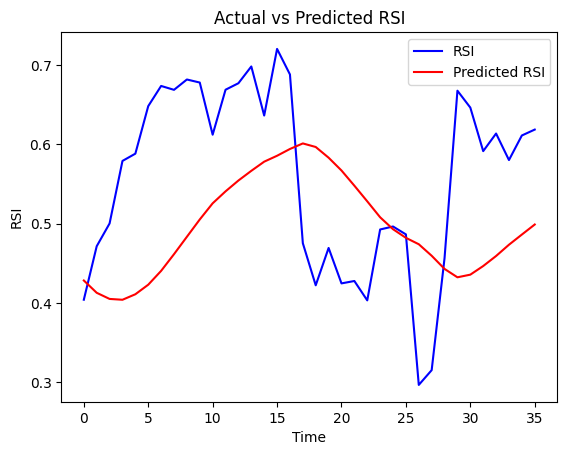

In [50]:
import matplotlib.pyplot as plt

plt.plot(data[3], color='blue', label='RSI')
plt.plot(model.predict(data[1]), color='red', label='Predicted RSI')
plt.title('Actual vs Predicted RSI')
plt.xlabel('Time')
plt.ylabel('RSI')
plt.legend()
plt.show()

## Trading Strategy

### Implementation and Backtesting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Cumulative Strategy Return: 0.07
Market Return: 0.07
Sharpe Ratio: 2.62


/var/folders/qy/v3h3mf7s06910rb44k37m4vr0000gn/T/ipykernel_90513/1168624501.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = signals['cumulative_strategy_returns'][-1] - 1
/var/folders/qy/v3h3mf7s06910rb44k37m4vr0000gn/T/ipykernel_90513/1168624501.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Market Return: {signals['cumulative_market_returns'][-1] - 1:.2f}")


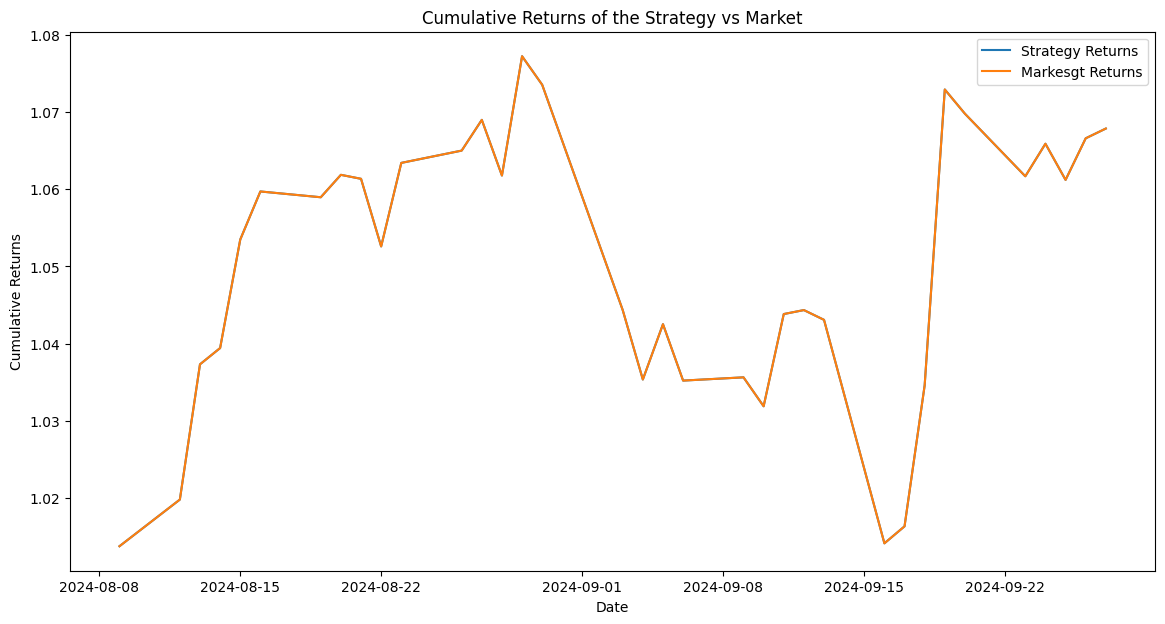

In [51]:
predictions = model.predict(data[1])

predicted_rsi, actual_rsi = scalers['AAPL'].inverse_transform(predictions),  scalers['AAPL'].inverse_transform(data[3].reshape(-1, 1))

signals = pd.DataFrame(index=stock_data['AAPL'].index[-len(predictions):])
signals['predicted_rsi'], signals['actual_rsi'], signals['signal'] = predicted_rsi, actual_rsi, 0

# Buy @ RSI < 30, sell @ RSI > 70
signals.loc[signals['predicted_rsi'] < 70, 'signal'], signals.loc[signals['predicted_rsi'] > 30, 'signal'] = -1, 1

signals['daily_returns'] = stock_data['AAPL']['Close'][-len(predictions):].pct_change()
signals['strategy_returns'] = signals['daily_returns'] * signals['signal'].shift(1)

signals['cumulative_strategy_returns'], signals['cumulative_market_returns'] = (1 + signals['strategy_returns']).cumprod(), (1 + signals['daily_returns']).cumprod()

cumulative_return = signals['cumulative_strategy_returns'][-1] - 1
sharpe_ratio = signals['strategy_returns'].mean() / signals['strategy_returns'].std() * np.sqrt(252)

print(f"Cumulative Strategy Return: {cumulative_return:.2f}")
print(f"Market Return: {signals['cumulative_market_returns'][-1] - 1:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

plt.figure(figsize=(14, 7))
plt.plot(signals['cumulative_strategy_returns'], label='Strategy Returns')
plt.plot(signals['cumulative_market_returns'], label='Markesgt Returns')
plt.title('Cumulative Returns of the Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()